In [50]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Load Data

In [51]:
df = pd.read_csv(Path("..", "data", "train.csv"))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Train-Test-Split

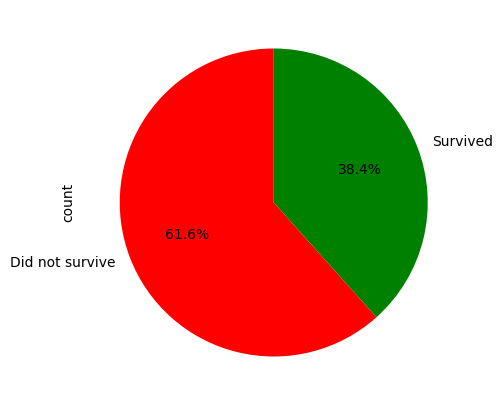

In [52]:
df["Survived"].value_counts().plot.pie(
    autopct="%1.1f%%",
    figsize=(5, 5),
    startangle=90,
    colors=["red", "green"],
    labels=["Did not survive", "Survived"],
)
plt.show()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Survived", axis=1),
    df["Survived"],
    test_size=0.2,
    random_state=42,
    stratify=df["Survived"],
)
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

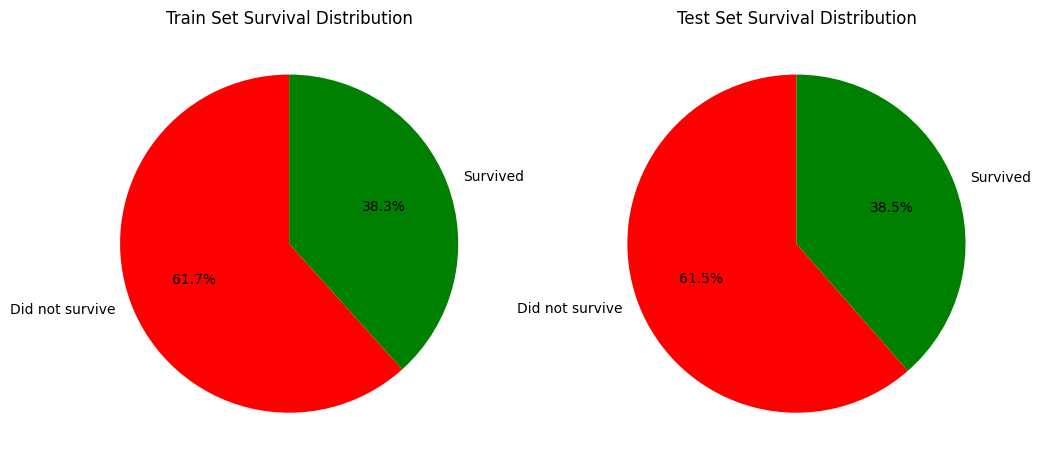

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train pie chart
axes[0].pie(
    y_train.value_counts().reindex([0, 1]),
    labels=["Did not survive", "Survived"],
    colors=["red", "green"],
    autopct="%1.1f%%",
    startangle=90,
)
axes[0].set_title("Train Set Survival Distribution")

# Test pie chart
axes[1].pie(
    y_test.value_counts().reindex([0, 1]),
    labels=["Did not survive", "Survived"],
    colors=["red", "green"],
    autopct="%1.1f%%",
    startangle=90,
)
axes[1].set_title("Test Set Survival Distribution")

plt.show()

# Data Preprocessing

Drop irrelevant columns and columns with majority of data missing
* PassengerId
* Name
* Ticket
* Cabin

In [55]:
X_train = X_train.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
692,3,male,NaN,0,0,56.4958,S
481,2,male,NaN,0,0,0.0000,S
527,1,male,NaN,0,0,221.7792,S
855,3,female,18.0,0,1,9.3500,S
801,2,female,31.0,1,1,26.2500,S


### One-Hot-Encode the Pclass

In [56]:
pclass_encoder = OneHotEncoder(sparse_output=False, drop="first")
pclass_encoded = pclass_encoder.fit_transform(X_train[["Pclass"]])
df_pclass_encoded = pd.DataFrame(
    pclass_encoded,
    columns=pclass_encoder.get_feature_names_out(["Pclass"]),
    index=X_train.index,
)
X_train = X_train.drop("Pclass", axis=1).join(df_pclass_encoded)
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Embarked,Pclass_2,Pclass_3
692,male,NaN,0,0,56.4958,S,0.0,1.0
481,male,NaN,0,0,0.0000,S,1.0,0.0
527,male,NaN,0,0,221.7792,S,0.0,0.0
855,female,18.0,0,1,9.3500,S,0.0,1.0
801,female,31.0,1,1,26.2500,S,1.0,0.0


### Transform Sex
* male -> 1
* female -> 0

In [57]:
X_train["Sex"] = X_train["Sex"].map({"male": 1, "female": 0})
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Embarked,Pclass_2,Pclass_3
692,1,NaN,0,0,56.4958,S,0.0,1.0
481,1,NaN,0,0,0.0000,S,1.0,0.0
527,1,NaN,0,0,221.7792,S,0.0,0.0
855,0,18.0,0,1,9.3500,S,0.0,1.0
801,0,31.0,1,1,26.2500,S,1.0,0.0


### Impute Age with Mean

In [58]:
age_imputer = SimpleImputer(strategy="mean")
X_train["Age"] = age_imputer.fit_transform(X_train[["Age"]])
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Embarked,Pclass_2,Pclass_3
692,1,29.807687,0,0,56.4958,S,0.0,1.0
481,1,29.807687,0,0,0.0000,S,1.0,0.0
527,1,29.807687,0,0,221.7792,S,0.0,0.0
855,0,18.000000,0,1,9.3500,S,0.0,1.0
801,0,31.000000,1,1,26.2500,S,1.0,0.0


### Impute Embarked with Most Frequent and apply One-Hot-Encoding

In [59]:
embarked_imputer = SimpleImputer(strategy="most_frequent")
X_train["Embarked"] = embarked_imputer.fit_transform(X_train[["Embarked"]]).ravel()
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Embarked,Pclass_2,Pclass_3
692,1,29.807687,0,0,56.4958,S,0.0,1.0
481,1,29.807687,0,0,0.0000,S,1.0,0.0
527,1,29.807687,0,0,221.7792,S,0.0,0.0
855,0,18.000000,0,1,9.3500,S,0.0,1.0
801,0,31.000000,1,1,26.2500,S,1.0,0.0


In [60]:
embarked_encoder = OneHotEncoder(sparse_output=False, drop="first")
embarked_encoded = embarked_encoder.fit_transform(X_train[["Embarked"]])
df_embarked_encoded = pd.DataFrame(
    embarked_encoded,
    columns=embarked_encoder.get_feature_names_out(["Embarked"]),
    index=X_train.index,
)
X_train = X_train.drop("Embarked", axis=1).join(df_embarked_encoded)
X_train.head()


,Sex,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
692,1,29.807687,0,0,56.4958,0.0,1.0,0.0,1.0
481,1,29.807687,0,0,0.0000,1.0,0.0,0.0,1.0
527,1,29.807687,0,0,221.7792,0.0,0.0,0.0,1.0
855,0,18.000000,0,1,9.3500,0.0,1.0,0.0,1.0
801,0,31.000000,1,1,26.2500,1.0,0.0,0.0,1.0


# Inspect Features

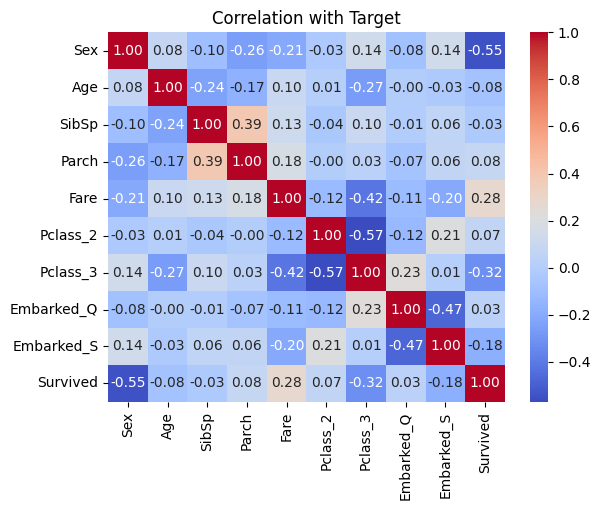

In [61]:
df_corr = X_train.join(y_train).corr()
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation with Target")
plt.show()

# Scale the Features
* Age
* Fare

In [62]:
age_scaler = StandardScaler()
fare_scaler = StandardScaler()

X_train["Age_scaled"] = age_scaler.fit_transform(X_train[["Age"]]).ravel()
X_train["Fare_scaled"] = fare_scaler.fit_transform(X_train[["Fare"]]).ravel()
X_train = X_train.drop(columns=["Age", "Fare"])

X_train.head()

,Sex,SibSp,Parch,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Age_scaled,Fare_scaled
692,1,0,0,0.0,1.0,0.0,1.0,-5.463229e-16,0.513812
481,1,0,0,1.0,0.0,0.0,1.0,-5.463229e-16,-0.662563
527,1,0,0,0.0,0.0,0.0,1.0,-5.463229e-16,3.955399
855,0,0,1,0.0,1.0,0.0,1.0,-9.078708e-01,-0.467874
801,0,1,1,1.0,0.0,0.0,1.0,9.167471e-02,-0.115977


# Combine Preprocessing into a single Pipeline

In [63]:
numeric_features = ["SibSp", "Parch"]
scale_features = ["Age", "Fare"]
sex_features = ["Sex"]
pclass_features = ["Pclass"]
embarked_features = ["Embarked"]

# Pipelines
numeric_pipeline = Pipeline([("passthrough", "passthrough")])

scale_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

sex_pipeline = Pipeline([("map", OneHotEncoder(drop="if_binary", dtype=int))])

pclass_pipeline = Pipeline(
    [("encoder", OneHotEncoder(drop="first", sparse_output=False))]
)

embarked_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first", sparse_output=False)),
    ]
)

# Preprocessor
preprocessor = ColumnTransformer(
    [
        ("num", numeric_pipeline, numeric_features),
        ("scale", scale_pipeline, scale_features),
        ("sex", sex_pipeline, sex_features),
        ("pclass", pclass_pipeline, pclass_features),
        ("embarked", embarked_pipeline, embarked_features),
    ]
)

# Model Pipeline
model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
    ]
)

# Check if Pipeline has same results like manual Preprocessing

In [64]:
import numpy as np

# Preprocess Data
preprocessor.fit(X_train_copy)

# Get Column Names
num_cols = ["SibSp", "Parch"]
scale_cols = ["Age_scaled", "Fare_scaled"]
sex_cols = ["Sex"]
pclass_cols = preprocessor.named_transformers_["pclass"][
    "encoder"
].get_feature_names_out(["Pclass"])
embarked_cols = preprocessor.named_transformers_["embarked"][
    "encoder"
].get_feature_names_out(["Embarked"])

# Create Preprocessed Dataframe
cols_preprocessed = np.concatenate(
    [num_cols, scale_cols, sex_cols, pclass_cols, embarked_cols]
)
X_train_processed = pd.DataFrame(
    preprocessor.transform(X_train_copy),
    columns=cols_preprocessed,
    index=X_train_copy.index,
)

X_train_processed.head()

,SibSp,Parch,Age_scaled,Fare_scaled,Sex,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
692,0.0,0.0,-5.463229e-16,0.513812,1.0,0.0,1.0,0.0,1.0
481,0.0,0.0,-5.463229e-16,-0.662563,1.0,1.0,0.0,0.0,1.0
527,0.0,0.0,-5.463229e-16,3.955399,1.0,0.0,0.0,0.0,1.0
855,0.0,1.0,-9.078708e-01,-0.467874,0.0,0.0,1.0,0.0,1.0
801,1.0,1.0,9.167471e-02,-0.115977,0.0,1.0,0.0,0.0,1.0


In [65]:
np.allclose(
    X_train_processed[sorted(X_train_processed.columns)],
    X_train[sorted(X_train.columns)],
)

True

# Train Model

In [66]:
model.fit(X_train_copy, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('scale', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [67]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7932960893854749
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       110
           1       0.78      0.65      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



# Simulate File-Upload

In [68]:
df_train = pd.read_csv(Path("..", "data", "train.csv"))
X = df_train.drop("Survived", axis=1)
y = df_train["Survived"]
model.fit(X, y)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('scale', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [69]:
X_test = pd.read_csv(Path("..", "data", "test.csv"))
y_pred = model.predict(X_test)
pd.DataFrame({"PassengerId": X_test["PassengerId"], "Survived": y_pred})

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
